In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd
%matplotlib inline 
import nltk
import string
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from mpl_toolkits.basemap import Basemap
from pandas import value_counts

## Twitter Data

### Import and join of json files with tweet data

The json data files for each day's tweets are pulled and appended to one another.

In [2]:
tweet_files = ['#NetNeutrality/#NetNeutrality_2018-01-22.json', 'net/net_2018-01-22.json', '#NetNeutrality/#NetNeutrality_2018-01-23.json', 'net/net_2018-01-23.json', '#NetNeutrality/#NetNeutrality_2018-01-24.json', 'net/net_2018-01-24.json', '#NetNeutrality/#NetNeutrality_2018-01-25.json', 'net/net_2018-01-25.json', '#NetNeutrality/#NetNeutrality_2018-01-26.json', 'net/net_2018-01-26.json', '#NetNeutrality/#NetNeutrality_2018-01-27.json', 'net/net_2018-01-27.json', '#NetNeutrality/#NetNeutrality_2018-01-28.json', 'net/net_2018-01-28.json', '#NetNeutrality/#NetNeutrality_2018-01-29.json', 'net/net_2018-01-29.json', '#NetNeutrality/#NetNeutrality_2018-01-30.json', 'net/net_2018-01-30.json', '#NetNeutrality/#NetNeutrality_2018-01-31.json', 'net/net_2018-01-31.json', '#NetNeutrality/#NetNeutrality_2018-02-01.json', 'net/net_2018-02-01.json', '#NetNeutrality/#NetNeutrality_2018-02-02.json', 'net/net_2018-02-02.json', '#NetNeutrality/#NetNeutrality_2018-02-03.json', 'net/net_2018-02-03.json', '#NetNeutrality/#NetNeutrality_2018-02-04.json', 'net/net_2018-02-04.json', '#NetNeutrality/#NetNeutrality_2018-02-05.json', 'net/net_2018-02-05.json', '#NetNeutrality/#NetNeutrality_2018-02-06.json', 'net/net_2018-02-06.json', '#NetNeutrality/#NetNeutrality_2018-02-07.json', 'net/net_2018-02-07.json', '#NetNeutrality/#NetNeutrality_2018-02-08.json', 'net/net_2018-02-08.json', '#NetNeutrality/#NetNeutrality_2018-02-09.json', 'net/net_2018-02-09.json', '#NetNeutrality/#NetNeutrality_2018-02-10.json', 'net/net_2018-02-10.json', '#NetNeutrality/#NetNeutrality_2018-02-11.json', 'net/net_2018-02-11.json', '#NetNeutrality/#NetNeutrality_2018-02-12.json', 'net/net_2018-02-12.json', '#NetNeutrality/#NetNeutrality_2018-02-13.json', 'net/net_2018-02-13.json', '#NetNeutrality/#NetNeutrality_2018-02-14.json', 'net/net_2018-02-14.json', '#NetNeutrality/#NetNeutrality_2018-02-15.json', 'net/net_2018-02-15.json', '#NetNeutrality/#NetNeutrality_2018-02-16.json', 'net/net_2018-02-16.json', '#NetNeutrality/#NetNeutrality_2018-02-17.json', 'net/net_2018-02-17.json']
tweets = []
for file in tweet_files:
    with open(file, 'r') as f:
        for line in f.readlines():
            tweets.append(json.loads(line))

### Data Wrangling

A number of steps can be taken to investigate and clean the tweet data prior to analysis.

#### Investigate fields of a tweet

In [3]:
print(tweets[0])

{'created_at': 'Mon Jan 22 23:59:48 +0000 2018', 'id': 955590854734958592, 'id_str': '955590854734958592', 'text': 'RT @MatthewBender9: #NetNeutrality How it’s going to look like https://t.co/sFqFXWVnOz', 'truncated': False, 'entities': {'hashtags': [{'text': 'NetNeutrality', 'indices': [20, 34]}], 'symbols': [], 'user_mentions': [{'screen_name': 'MatthewBender9', 'name': 'Ghillie', 'id': 2425832674, 'id_str': '2425832674', 'indices': [3, 18]}], 'urls': [], 'media': [{'id': 941417228330766337, 'id_str': '941417228330766337', 'indices': [63, 86], 'media_url': 'http://pbs.twimg.com/media/DRCV-zgWkAE7eaB.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DRCV-zgWkAE7eaB.jpg', 'url': 'https://t.co/sFqFXWVnOz', 'display_url': 'pic.twitter.com/sFqFXWVnOz', 'expanded_url': 'https://twitter.com/MatthewBender9/status/941417235545018370/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 1200, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 680, '

#### Definition of features to be created in dataframe from json files

In [4]:
def populate_tweet_df(tweets):
    df = pd.DataFrame()
    df['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets))                
    df['tweet_date'] = list(map(lambda tweet: tweet['created_at'], tweets))
    df['user_id'] = list(map(lambda tweet: tweet['user']['id'], tweets))                      
    df['screen_name'] = list(map(lambda tweet: tweet['user']['screen_name'], tweets))                
    df['name'] = list(map(lambda tweet: tweet['user']['name'], tweets))               
    df['description'] = list(map(lambda tweet: tweet['user']['description'], tweets))                
    df['text'] = list(map(lambda tweet: tweet['text'], tweets))
    df['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets))
    df['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets))               
    df['user_location'] = list(map(lambda tweet: tweet['user']['location'] 
                        if tweet['place'] != None else '', tweets))
    df['tweet_location'] = list(map(lambda tweet: tweet['place']['full_name'] 
                        if tweet['place'] != None else '', tweets))
    df['long'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][0]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    df['latt'] = list(map(lambda tweet: tweet['coordinates']['coordinates'][1]
                        if tweet['coordinates'] != None else 'NaN', tweets))
    return df

In [5]:
# Create pandas dataframe
df = populate_tweet_df(tweets)

In [6]:
df.shape

(304403, 13)

In [7]:
df.tweet_id.nunique()

279701

In [8]:
# Remove duplicate tweets
df = df.drop_duplicates(["tweet_id"])
df.shape

(279701, 13)

In [9]:
df.isnull().sum()

tweet_id          0
tweet_date        0
user_id           0
screen_name       0
name              0
description       0
text              0
retweet_count     0
favorite_count    0
user_location     0
tweet_location    0
long              0
latt              0
dtype: int64

In [10]:
# Look at data types
df.dtypes

tweet_id           int64
tweet_date        object
user_id            int64
screen_name       object
name              object
description       object
text              object
retweet_count      int64
favorite_count     int64
user_location     object
tweet_location    object
long              object
latt              object
dtype: object

In [11]:
# Convert tweet date to a datetime object
df['tweet_date'] = pd.to_datetime(df['tweet_date'],  errors='raise')
df.dtypes

tweet_id                   int64
tweet_date        datetime64[ns]
user_id                    int64
screen_name               object
name                      object
description               object
text                      object
retweet_count              int64
favorite_count             int64
user_location             object
tweet_location            object
long                      object
latt                      object
dtype: object

In [12]:
def parse_location(string):
    if (string.split(',')[-1] == ' USA'):
        return string.split(',')[0]
    else:
        return string.split(', ')[-1]

In [13]:
df['state'] = df['tweet_location'].map(parse_location)

In [14]:
statedict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [15]:
for key, value in statedict.items():
    df['state'] = df['state'].replace(key, value)

In [59]:
otherlocdict = {
        'Alberta': 'Outside US',
        'Algarrobos': 'Outside US',
        'Amherst Regional Middle School': 'Massachusetts',
        'Apulia': 'Outside US',
        'Argentina': 'Outside US',
        'Austria': 'Outside US',
        'Bahamas': 'Outside US',
        'Baja California': 'Outside US',
        'Barbados': 'Outside US',
        'Barcelona': 'Outside US',
        'Bavaria': 'Outside US',
        'Bayamón': 'Outside US',
        'Belgium': 'Outside US',
        'België': 'Outside US',
        'Berlin': 'Outside US',
        'Brasil': 'Outside US',
        'Brazil': 'Outside US',
        'British Columbia': 'Outside US',
        'California State Capitol Building': 'California',
        'Campania': 'Outside US',
        'Canada': 'Outside US',
        'Carolina Bay': 'North Carolina',
        'Caveat': 'Outside US',
        'Changwat Chon Buri': 'Outside US',
        'Channel Islands Harbor Green Navigation Light': 'California',
        'Chicago': 'Illinois',
        'Chihuahua': 'Outside US',
        'Chile': 'Outside US',
        'Colombia': 'Outside US',
        'Costa Rica': 'Outside US',
        'Cuba': 'Outside US',
        'Czech Republic': 'Outside US',
        'Davao Region': 'Outside US',
        'Denmark': 'Outside US',
        'Deutschland': 'Outside US',
        'Distrito Federal': 'Outside US',
        'Dovetail Brewing': 'Illinois',
        'Duluth MN-Superior WI': 'Minnesota',
        'East': 'Outside US',
        'Ecuador': 'Outside US',
        'El Salvador': 'Outside US',
        'England': 'Outside US',
        'Espanya': 'Outside US',
        'España': 'Outside US',
        'Finland': 'Outside US',
        'France': 'Outside US',
        'Frankfurt Airport': 'Outside US',
        'Germany': 'Outside US',
        'Hato Rey Sur': 'Puerto Rico',
        'Honduras': 'Outside US',
        'Hong Kong': 'Outside US',
        'Hungary': 'Outside US',
        'Iceland': 'Outside US',
        'India': 'Outside US',
        'Indonesia': 'Outside US',
        'Ireland': 'Outside US',
        'Isle of Man': 'Outside US',
        'Israel': 'Outside US',
        'Jamaica': 'Outside US',
        'Kingdom of Saudi Arabia': 'Outside US',
        'Kuala Lumpur Federal Territory': 'Outside US',
        'Lazio': 'Outside US',
        'Liguria': 'Outside US',
        'Lombardia': 'Outside US',
        'Lombardy': 'Outside US',
        'London': 'Outside US',
        'Los Angeles': 'California',
        'Luxembourg': 'Outside US',
        'Maldives': 'Outside US',
        'Manitoba': 'Outside US',
        'Marche': 'Outside US',
        'Massachusetts State House': 'Massachusetts',
        'Mordor': 'Outside US',
        'München': 'Outside US',
        'National Capital Region': 'District of Columbia',
        'Nederland': 'Colorado',
        'Nepal': 'Outside US',
        'New South Wales': 'Outside US',
        'New Zealand': 'Outside US',
        'Newfoundland and Labrador': 'Outside US',
        'Newseum - Knight Conference Center': 'District of Columbia',
        'Nigeria': 'Outside US',
        'Norge': 'Outside US',
        'Northern Essex Community College': 'Outside US',
        'Northern Ireland': 'Outside US',
        'Nova Scotia': 'Outside US',
        'Nuevo León': 'Outside US',
        'Nürnberg': 'Outside US',
        'Odessa High School': 'Texas',
        'Ontario': 'Outside US',
        'Osaka': 'Outside US',
        'Paradise': 'Outside US',
        "People's Republic of China": 'Outside US',
        'Perlis': 'Louisiana',
        'Piedmont': 'Outside US',
        'Playa': 'Outside US',
        'Poland': 'Outside US',
        'Portland': 'Oregon',
        'Queens': 'New York',
        'Queensland': 'Outside US',
        'Quintana Roo': 'Outside US',
        'Québec': 'Outside US',
        'Republic of Korea': 'Outside US',
        'Rhode Island State House': 'Rhode Island',
        'Rochester': 'New York',
        'Romania': 'Outside US',
        'Sacramento State': 'California',
        'Sarawak': 'Outside US',
        'Saskatchewan': 'Outside US',
        'Schleswig-Holstein': 'Outside US',
        'Scotland': 'Outside US',
        'Seattle': 'Washington',
        'Singapore': 'Outside US',
        'South Africa': 'Outside US',
        'Spain': 'Outside US',
        'Sri Lanka': 'Outside US',
        'Suomi': 'Outside US',
        'Sweden': 'Outside US',
        'Switzerland': 'Outside US',
        'Taiwan': 'Outside US',
        'Tasmania': 'Outside US',
        'Thailand': 'Outside US',
        'The Netherlands': 'Outside US',
        'The Urban Hive': 'California',
        'Tokyo': 'Outside US',
        'Tokyo 23 ward': 'Outside US',
        'Toronto': 'Outside US',
        'Trinidad and Tobago': 'Outside US',
        'United Arab Emirates': 'Outside US',
        'United Kingdom': 'Outside US',
        'University of Glasgow': 'Outside US',
        'University of La Verne': 'California',
        'VCU Pocahontas Building': 'Virginia',
        'Veneto': 'Outside US',
        'Victoria': 'Outside US',
        'Vintage Marina C19': 'California',
        'Wales': 'Outside US',
        'Washington D.C.': 'District of Columbia',
        'Yamaguchi': 'Outside US'
}

In [60]:
for key, value in otherlocdict.items():
    df['state'] = df['state'].replace(key, value)

## Exploratory Data Analysis

In [18]:
df.head()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt,state
0,955590854734958592,2018-01-22 23:59:48,813084079180709888,SamanthaRblxYT,sam🦄,I LOVE MA GURPS!! @YourLilPotato & @Little_Sno...,RT @MatthewBender9: #NetNeutrality How it’s go...,1291,0,,,NaN,NaN,
1,955590762271526912,2018-01-22 23:59:26,830465545275371521,margeholmes6162,Marj,,RT @DeadpoolResists: Montana becomes first sta...,475,0,,,NaN,NaN,
2,955590754033946634,2018-01-22 23:59:24,3246707126,AllMghtyLantern,AllMightyLantern,"Lover of all things comics, games, animation, ...",RT @fightfortheftr: We are ONE VOTE AWAY from ...,839,0,,,NaN,NaN,
3,955590534789124096,2018-01-22 23:58:32,786420072730333184,pyrrpro55,Pyrrhis Productions,Formerly Simulation Studios!,RT @freepress: Don't be fooled: Your activism ...,35,0,,,NaN,NaN,
4,955590495950041088,2018-01-22 23:58:22,1603164476,bzaenglein,Barbara Zaenglein,#Resist #Notmypresident. #NetNeutrality #Pence...,RT @freepress: We're suing the FCC to save #Ne...,36,0,,,NaN,NaN,


In [19]:
df.tail()

,tweet_id,tweet_date,user_id,screen_name,name,description,text,retweet_count,favorite_count,user_location,tweet_location,long,latt,state
304398,964651240549486593,2018-02-17 00:02:32,912414397649350659,CyberMonitor02,CyberMonitor02,,Vermont becomes fourth US state to boot up its...,0,0,,,NaN,NaN,
304399,964651227454853122,2018-02-17 00:02:29,767017401133203460,poppy_palace,Poppy's Palace,A pup having fun hanging out with my pack..!,RT @Ravelong: FCC chairman Ajit Pai is under i...,142,0,,,NaN,NaN,
304400,964651059586232320,2018-02-17 00:01:49,95762059,Kilgoar,Kilgoar,avatar is the face of vitiated glenn runciter RIP,"@KalyptoNet cyberlibertarianism, specifically,...",0,0,,,NaN,NaN,
304401,964650624855011329,2018-02-17 00:00:05,2740661509,morganlyons97,𝓶𝓸𝓻𝓰𝓪𝓷,"well geez Louise, i can’t control the weather!...",for everyone who signed the petition for net n...,1,2,,,NaN,NaN,
304402,964650624045408256,2018-02-17 00:00:05,3885947478,JohnSpensieri1,John Spensieri,"Buy American hire American. #SchumerShutDown ""...",Thousands died too! Just like they did from Ta...,0,0,,,NaN,NaN,


In [20]:
df.describe()

,tweet_id,user_id,retweet_count,favorite_count
count,2.797010e+05,2.797010e+05,279701.000000,279701.000000
mean,9.582285e+17,1.898229e+17,3483.059585,1.503888
std,2.552861e+15,3.529501e+17,10521.658055,123.241721
min,9.552285e+17,6.600000e+01,0.000000,0.000000
25%,9.563327e+17,1.153087e+08,0.000000,0.000000
50%,9.569489e+17,8.266372e+08,24.000000,0.000000
75%,9.597120e+17,4.160788e+09,595.000000,0.000000
max,9.649858e+17,9.649641e+17,337360.000000,43342.000000


#### Date Range of the Data

In [21]:
# Let's look at the date range we have here
print("Earliest Tweet", df['tweet_date'].min())
print("Latest Tweet", df['tweet_date'].max())

Earliest Tweet 2018-01-22 00:00:02
Latest Tweet 2018-02-17 22:11:47


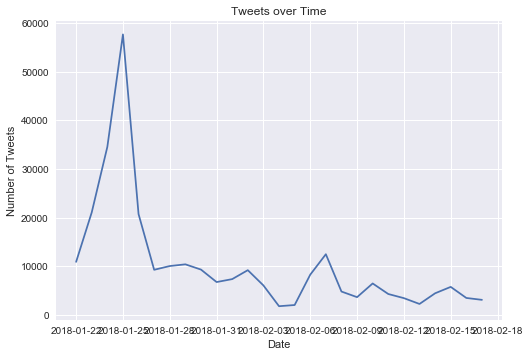

In [22]:
df.groupby(df['tweet_date'].dt.date).size().plot()
plt.title('Tweets over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

#### Process text for analysis

In [23]:
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
words = (df['text']
           .str.lower()
           .replace([r'\|', RE_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

#### Most frequent words

In [24]:
rslt = pd.DataFrame(Counter(words).most_common(50),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt = rslt.iloc[5:] 
#top terms removed from graph because they are the search terms for the data collection

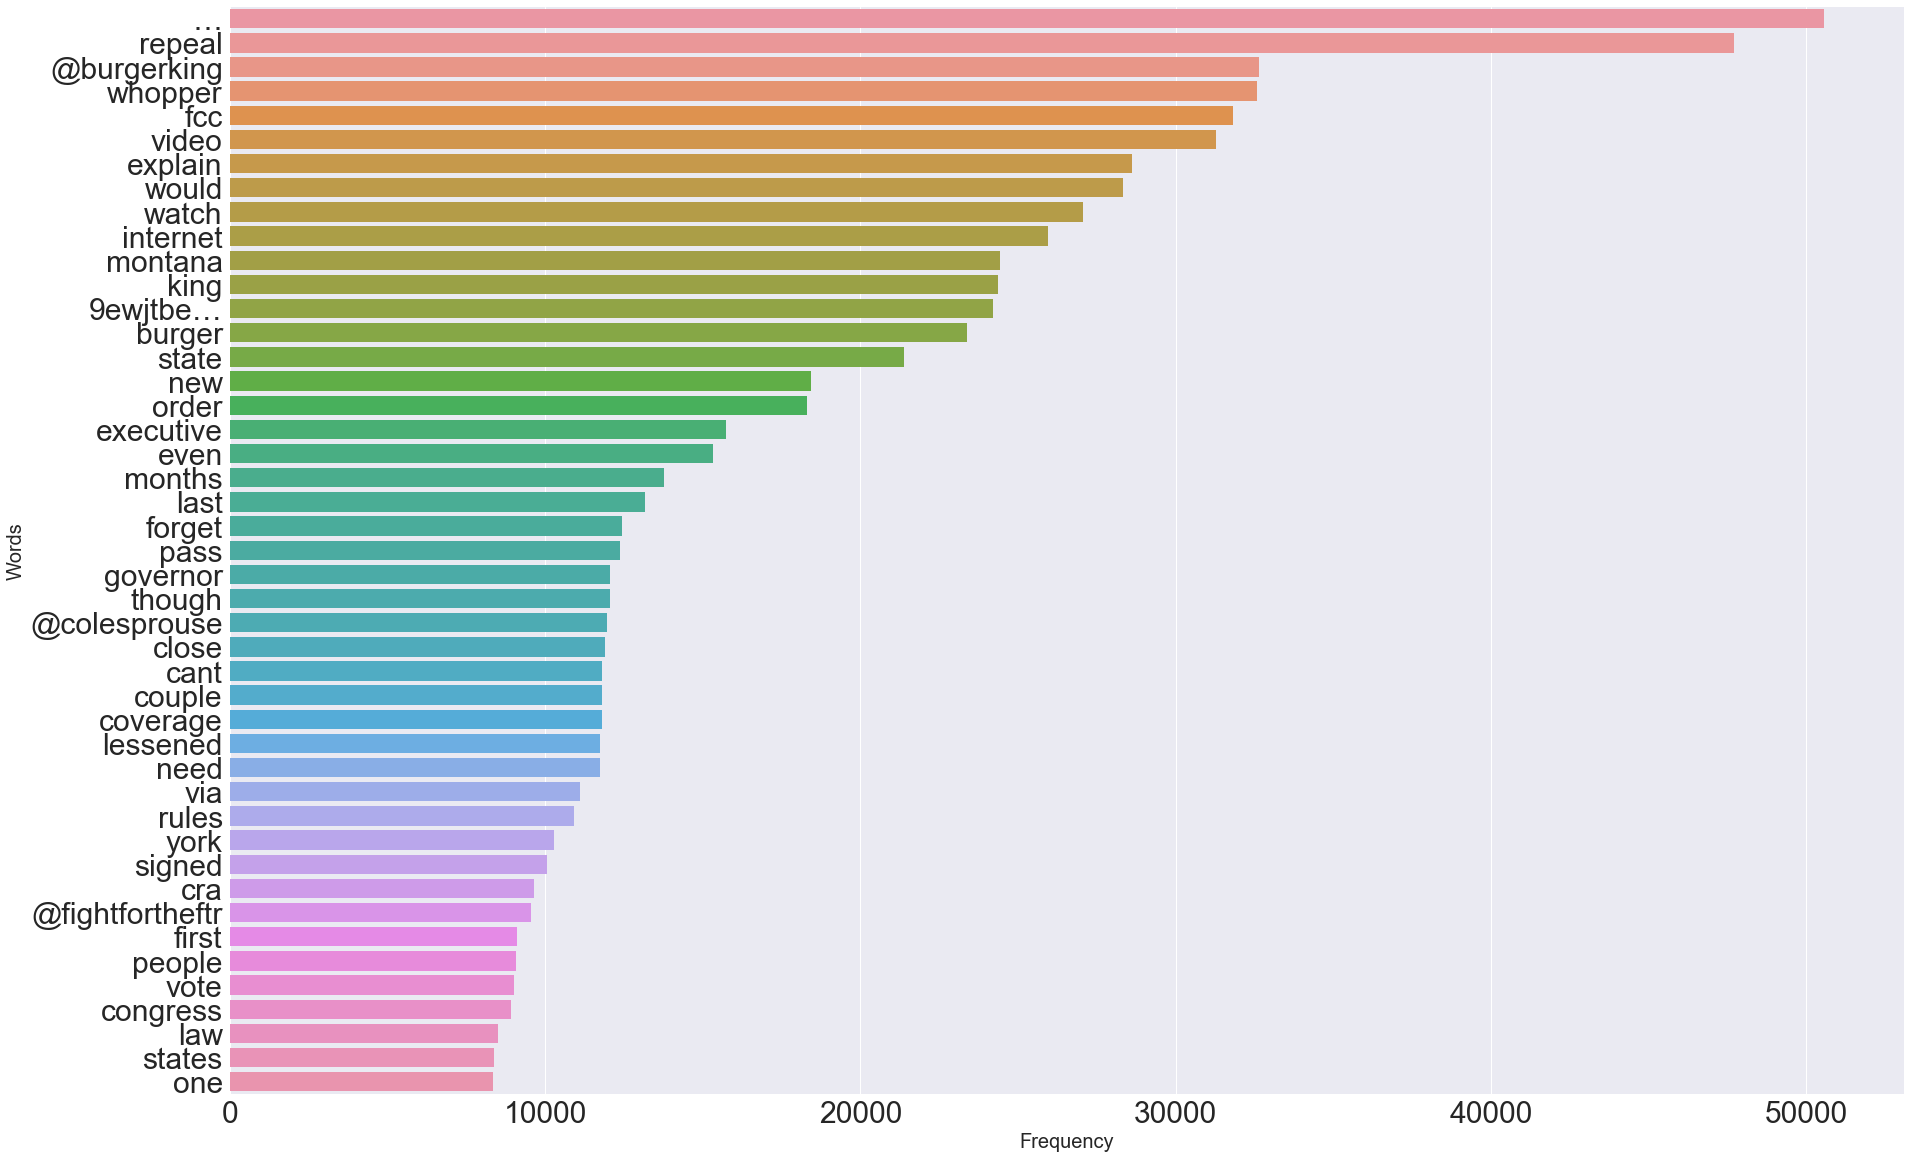

In [25]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=rslt.index, x='Frequency', data=rslt)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

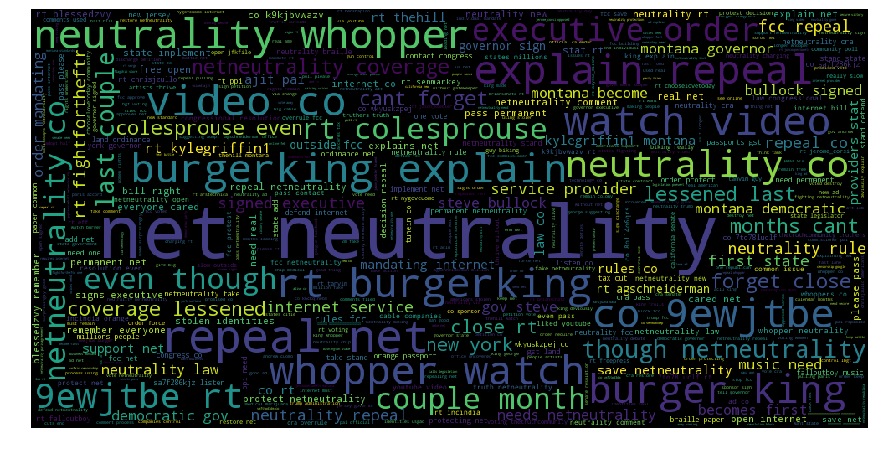

In [26]:
wordcloud = WordCloud(width = 1000, height = 500, max_words = 500).generate(' '.join(words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Word Co-Occurrences

In [27]:
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words, 2)
finder.apply_freq_filter(5)
for bigram in finder.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)

('net', 'neutrality')
('burger', 'king')
('would', 'explain')
('watch', 'video')
('whopper', 'watch')
('@burgerking', 'would')
('explain', 'repeal')
('executive', 'order')
('coverage', 'lessened')
('cant', 'forget')
('forget', 'close')
('lessened', 'last')
('last', 'couple')
('couple', 'months')
('months', 'cant')
('co', '9ewjtbe…')
('even', 'though')
('@colesprouse', 'even')
('video', 'co')
('repeal', 'net')


#### Most Frequent Links

In [28]:
def extract_link(text):
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

In [29]:
df['link'] = df['text'].apply(lambda tweet: extract_link(tweet))
tweets_with_link = df[df['link'] != '']

In [30]:
rslt3 = pd.DataFrame(Counter(tweets_with_link['link']).most_common(10),
                    columns=['Link', 'Frequency']).set_index('Link')

rslt3 = rslt3.iloc[1:]

In [31]:
print(rslt3)

                         Frequency
Link                              
https://t.co/K9kjBvwazV       2729
https://t.co/sA7f286KJZ       2170
https://t.co/wkyUSkzpeJ       2124
https://t.co/…                1311
https://t.co/k6CkqtnEB8       1044
https://t.co/vmfTTWd3dM        815
https://t.co/vEtEqo1dTG        656
https://t.co/oabVsUk0sc        583
https://t.co/FOwGhk4B7a        552


#### Tweets by Location

In [101]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [77]:
import plotly
plotly.tools.set_credentials_file(username='bouncebarkrun', api_key='xxxxx')

In [144]:
df2 = df[['tweet_id', 'state']]

In [145]:
for key, value in us_state_abbrev.items():
    df2['state'] = df2['state'].replace(key, value)

In [146]:
df2 = df2.pivot_table(index='state', aggfunc='count')

In [147]:
df2 = df2.drop(['', 'Burger King', 'IHOP', 'Outside US', 'Puerto Rico', 'United States', 'Yogurtland'])

In [148]:
df2['states'] = df2.index
df2['numtweets'] = df2['tweet_id']

In [150]:
df2['states'] = df2['states'].astype(str)

In [164]:
scl = [[0.0, 'rgb(242,240,247)'],[50, 'rgb(218,218,235)'],[100, 'rgb(188,189,220)'],\
            [200, 'rgb(158,154,200)'],[300, 'rgb(117,107,177)'],[400, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df2['states'],
        z = df2['numtweets'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Tweets")
        ) ]

layout = dict(
        title = 'Net Neutrality Tweets by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~bouncebarkrun/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


#### Top Users

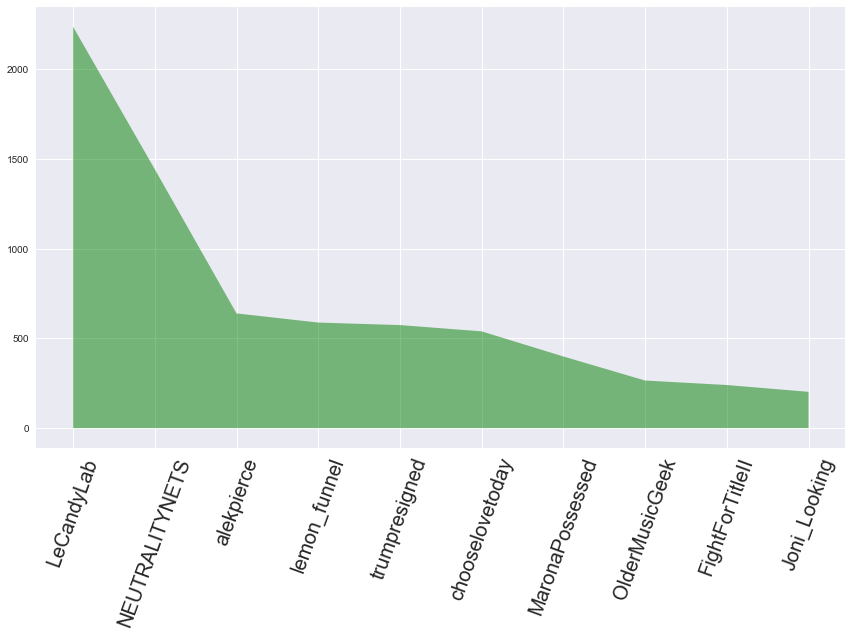

In [153]:
user_counts = df.screen_name.value_counts()[:10]
fig, ax = plt.subplots(1, figsize=(12, 9))
x = np.arange(len(user_counts.index))
ax.stackplot(x, user_counts.values, colors='g', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(user_counts.index, fontsize=20, rotation=70)
ax.grid(color='w', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

## FCC Public Comments Data

#### Import Data

In [154]:
fcc = pd.read_csv('~/Desktop/proc_17_108_unique_comments_text_dupe_count.csv', index_col='docid')

#### Data Wrangling

In [155]:
fcc.head()

,text_data,dupe_count
docid,,
2,I work as an engineering manager at a small vi...,1.0
3,"Dear FCC,\r\n\r\nclowns. traitors. pawns pre...",1.0
5,I am AGAINST the push to remove net neutrality...,1.0
6,"Guys, I seriously don't understand your reason...",1.0
8,I do not support this proposal. Having a neut...,1.0


In [156]:
fcc.shape

(2955186, 2)

In [157]:
fcc.text_data.nunique()

2955181

In [158]:
# Remove duplicate comments
fcc = fcc.drop_duplicates(["text_data"])
fcc.shape

(2955182, 2)

In [159]:
fcc.dtypes

text_data      object
dupe_count    float64
dtype: object

#### Exploratory Data Analysis

In [160]:
fccwords = (fcc['text_data']
           .str.lower()
           .replace([r'\|', RE_stopwords, r"(&amp)|,|;|\"|\.|\?|’|!|'|:|-|\\|/|https"], [' ', ' ', ' '], regex=True)
           .str.cat(sep=' ')
           .split()
)

In [161]:
rslt4 = pd.DataFrame(Counter(fccwords).most_common(50),
                    columns=['Word', 'Frequency']).set_index('Word')

rslt4 = rslt4.iloc[1:]

#### Most frequent words

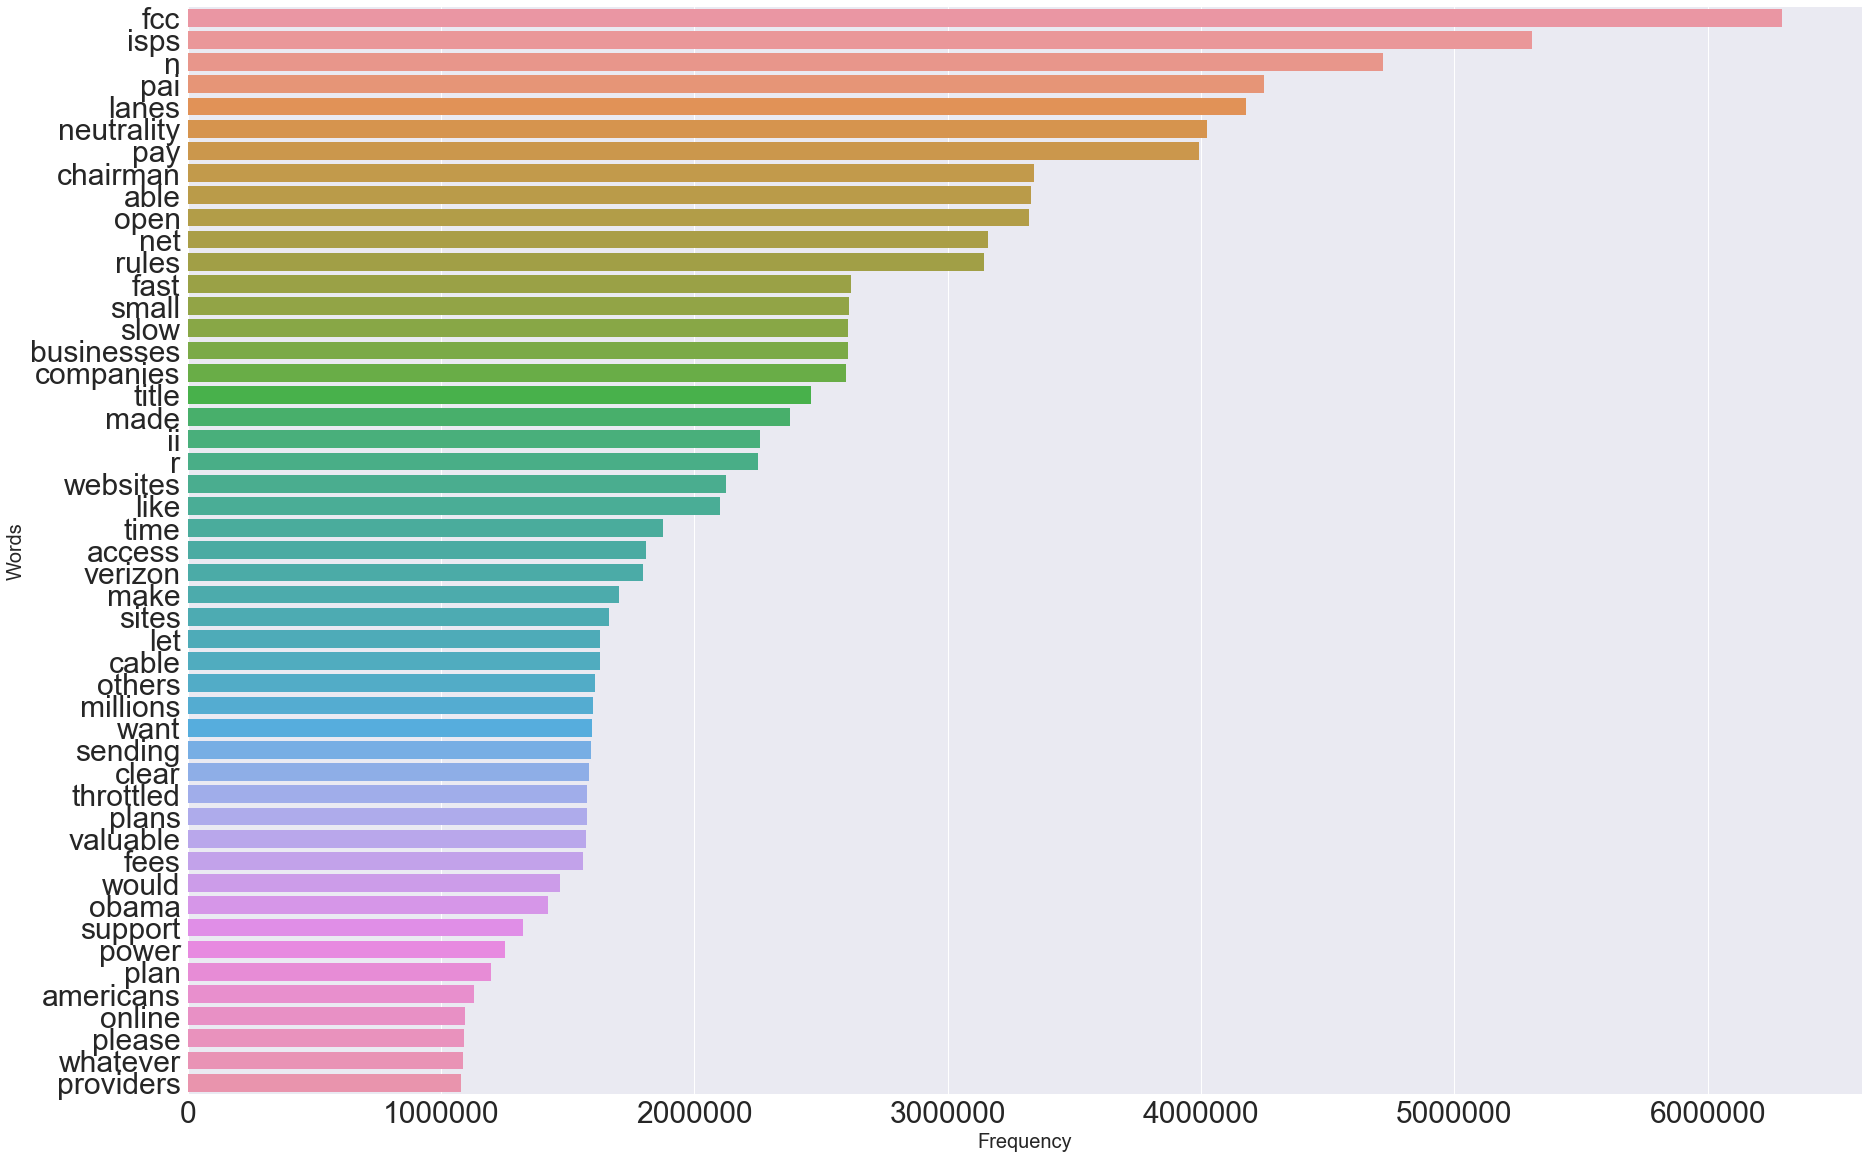

In [162]:
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = [30.0, 20.0]
ax = sns.barplot(y=rslt4.index, x='Frequency', data=rslt4)
ax.set_xlabel("Frequency",fontsize=20)
ax.set_ylabel("Words",fontsize=20)
ax.tick_params(labelsize=30)

In [163]:
finder2 = BigramCollocationFinder.from_words(fccwords, 2)
finder2.apply_freq_filter(5)
for bigram in finder2.nbest(bigram_measures.likelihood_ratio, 20):
    print(bigram)

('net', 'neutrality')
('chairman', 'pai')
('title', 'ii')
('fast', 'lanes')
('made', 'clear')
('small', 'businesses')
('league', 'legends')
('members', 'congress')
('famous', 'sky')
('admitted', 'introduce')
('rules)', 'extremely')
('serious', 'problem')
('abysmal', 'customer')
('marketplace', 'enabled')
('prices', 'abysmal')
('game', 'league')
('blogs', 'nonprofits')
('nonprofits', 'artists')
('created', '5')
('popular', 'game')
